> **How to run this notebook (command-line)?**
1. Install the `ReinventCommunity` environment:
`conda env create -f environment.yml`
2. Activate the environment:
`conda activate ReinventCommunity`
3. Execute `jupyter`:
`jupyter notebook`
4. Copy the link to a browser

# `Lib-INVENT`: Reinforcement Learning - QSAR model 

This tutorial covers the assembly of the `JSON` configuration for a reinforcement learning (RL) run where the scoring function involves only a predictive QSAR model for the DRD2 receptor.

In [1]:
# load dependencies
import os
import re
import json
import tempfile

# --------- change these path variables as required
reinvent_dir = os.path.expanduser("~/Desktop/Reinvent")
reinvent_env = os.path.expanduser("~/miniconda3/envs/reinvent.v3.2")
output_dir = os.path.expanduser("~/Desktop/REINVENT_RL_QSAR_demo")

# --------- do not change
# get the notebook's root path
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

# if required, generate a folder to store the results
try:
    os.mkdir(output_dir)
except FileExistsError:
    pass

## Setting up the configuration
`REINVENT` has an entry point that loads a specified `JSON` file on startup. `JSON` is a low-level data format that allows to specify a fairly large number of parameters in a cascading fashion very quickly. The parameters are structured into *blocks* which can in turn contain blocks or simple values, such as *True* or *False*, strings and numbers. In this tutorial, we will go through the different blocks step-by-step, explaining their purpose and potential values for given parameters. Note, that while we will write out the configuration as a `JSON` file in the end, in Python we handle the same information as a simple `dict`.

### 1. Run Type Block

In [2]:
# initialize the dictionary
configuration = {
    "version": 3,
    "model_type": "lib_invent",
    "run_type": "reinforcement_learning"
}

### 2. Logging
In order to analyse the results of any run afterwards, it is paramount to *log* intermediate results, e.g., to judge whether the agent has been focused enough (or too much), whether the learning is going well and so on. On top of this, we also need to make sure the final result (compounds) is deposited appropriately. Thus, we will log these data to two folders and inspect it afterwards with `tensorboard`, which is already installed in the environment.

In [3]:
# add block to specify whether to run locally or not and
# where to store the results and logging
configuration["logging"] = {
    "sender": "",                          # only relevant if "recipient" is set to "remote"
    "recipient": "local",                  # either to local logging or use a remote REST-interface
    "logging_path": os.path.join(output_dir, "progress.log"), # load this folder in tensorboard
    "result_folder": os.path.join(output_dir, "results"), # output directory for results
    "job_name": "Reinforcement learning QSAR demo",           # set an arbitrary job name for identification
    "job_id": "n/a"                        # only relevant if "recipient" is set to "remote"
}

### 3. Parameters Block
All of the remaining specifications and arguments are passed through a final block named `parameters`.

For RL, this requires standard run parameters such as the number of steps and learning rate, paths to the pretrained model as well as the configuration of the scoring function.

The `actor` and `critic` parameters should point to pretrained priors. In production setups, this is typically the same setup. The critic serves as an anchor ensuring that the SMILES syntax is not forgotten while the agent learns.

`scaffolds` gives a list of SMILES strings of the scaffolds to be decorated in the run. Note that the attachment points should be labeled by an integer.

`randomize_scaffolds` is a boolean parameter specifying whether a random SMILES representation of the scaffolds should be used at each step. Crucially, this is not yet possible if a selective reaction filter is imposed.

The DAP learning strategy is recommended in production runs.

In [4]:
# add the "parameters" block
configuration["parameters"] = {}

configuration["parameters"] = {
    "actor": os.path.join(ipynb_path, "models/library_design.prior"),
    "critic": os.path.join(ipynb_path, "models/library_design.prior"),
    "scaffolds": ["[*:0]N1CCN(CC1)CCCCN[*:1]"],
    "n_steps": 100,
    "learning_rate": 0.0001,
    "batch_size": 128,
    "randomize_scaffolds": True,
    "learning_strategy": {
        "name": "dap", 
        "parameters": {
        "sigma": 120
        }
    }
}

#### Configure the scoring strategy
This includes setting up `Diversity Filters`, `Reaction Filters` and a `Scoring Function`.
Only standard scoring strategy is offered to the end user.

In [5]:
configuration["parameters"]["scoring_strategy"] = {
    "name": "lib_invent" # Do not change
}

##### Configure Diversity Filter
Diversity Filters (DFs) are used to penalize repetition, thus preventing the agent from ending up in a mode collapse. The implementation is different from the diversity filters in other `REINVENT` models. Due to the nature of the task, scaffold-based DFs are not used. Instead, only repetition of entire compounds is supported.

The two DF options are `NoFilter` which doesn't penalize at all and `NoFilterWithPenalty` which penalizes the score by 0.5 if a previously seen compound is proposed.

In [6]:
configuration["parameters"]["scoring_strategy"]["diversity_filter"] =  {
    "name": "NoFilterWithPenalty",     
}

##### Configure Reaction Filter
Reaction Filters (RFs) are a penalty component enforcing that only decorations obtainable through specified chemical transformations are generated. 

The `selective` filter assigns a specific reaction to each attachment point. The `non_selective` filter does not determine which reactions correspond to which attachment points.

Multiple relevant reactions can be assigned in both cases.

More details on the expected inputs can be found in the `Lib-INVENT_RL2_QSAR_RF` tutorial.

In [7]:
configuration["parameters"]["scoring_strategy"]["reaction_filter"] =  {
    "type":"selective",        
    "reactions":[] # no reactions are imposed.
}

##### Define the scoring function
The final step of the assembly is the most essential one: to define a scoring function that allows the agent to identify promising suggestions and discard molecules that are of no interest to the project. It is not necessarily better to build a very complex scoring function (on the contrary it can make it hard for the agent to find appropriate solutions). Always bear in mind that there is a post-processing step at the end, in which you will be able to discard molecules either by eye-inspection or by applying further (probably more expensive) methods you have not used in the reinforcement learning loop. 

In this example, the scoring function includes a QSAR predictive model and custom alerts penalising undesirable patterns. More use cases can be found in the other tutorials. The individual scoring components are sub-dictionaries passed as a list to the `parameters` block within the `scoring_function` block.


**Score transformation**
An important topic requiring some explanation are the *score transformations*. Each scoring component returns a value between 0 and 1 (where higher values meaning "better") and all scores together are combined into a *total score* for a given compound (also between 0 and 1). This is done either by a weighed average (`custom_sum`) or by a product (`custom_product`). 

Since some components might not naturally return values on this scale, score transformations are offered to map the output of the component to the range $[0, 1]$. These transformations involve a sigmoid, reverse sigmoid and double sigmoid functions with flexible parameters to give the user a control over the strictness of the penalty. 

For clarity, the individual components are defined first here. Note that while the `name` parameter can be arbitrary and chose by the user, the `component_type` has to be recognised by the scoring function.

In the second step, the entire scoring function block is assembled.

In [8]:
scoring_function = {
    "name": "custom_sum", 
    "parallel": False,  # Do not change                   
    
    "parameters": [
     {
        "component_type": "predictive_property",
        "name": "DRD2",
        "weight": 1,
        "specific_parameters": {
            "model_path": os.path.join(ipynb_path, "models/drd2.pkl"),
            "scikit": "classification",
            "descriptor_type": "ecfp",
            "size": 2048,
            "radius": 3,
            "transformation": {
                "transformation_type": "no_transformation"
            }
        }
     },
     {
        "component_type": "custom_alerts",
        "name": "Custom alerts",               
        "weight": 1,                                            
        "specific_parameters": {       
            "smiles": [                           
                "[*;r8]",
                "[*;r9]",
                "[*;r10]",
                "[*;r11]",
                "[*;r12]",
                "[*;r13]",
                "[*;r14]",
                "[*;r15]",
                "[*;r16]",
                "[*;r17]",
                "[#8][#8]",
                "[#6;+]",
                "[#16][#16]",
                "[#7;!n][S;!$(S(=O)=O)]",
                "[#7;!n][#7;!n]",
                "C#C",
                "C(=[O,S])[O,S]",
                "[#7;!n][C;!$(C(=[O,N])[N,O])][#16;!s]",
                "[#7;!n][C;!$(C(=[O,N])[N,O])][#7;!n]",
                "[#7;!n][C;!$(C(=[O,N])[N,O])][#8;!o]",
                "[#8;!o][C;!$(C(=[O,N])[N,O])][#16;!s]",
                "[#8;!o][C;!$(C(=[O,N])[N,O])][#8;!o]",
                "[#16;!s][C;!$(C(=[O,N])[N,O])][#16;!s]"
            ]
        }
    }]
}

configuration["parameters"]["scoring_strategy"]["scoring_function"] = scoring_function

We now have successfully filled the dictionary and will write it out as a `JSON` file in the output directory. Please have a look at the file before proceeding in order to see how the paths have been inserted where required and the `dict` -> `JSON` translations (e.g. `True` to `true`) have taken place.

In [9]:
# write out the configuration to disc
configuration_JSON_path = os.path.join(output_dir, "RL_QSAR_input.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(configuration, f, indent=4, sort_keys=True)

The resulting configruation file should be placed in the `output_dir` path you specified in the beginning of this notebook.

# Run
Execute in jupyter notebook

In [10]:
%%capture captured_err_stream --no-stderr

# execute REINVENT from the command-line
!{reinvent_env}/bin/python {reinvent_dir}/input.py {configuration_JSON_path}

In [11]:
# print the output to a file, just to have it for documentation
with open(os.path.join(output_dir, "run.err"), 'w') as file:
    file.write(captured_err_stream.stdout)

Execute in command line
```
# activate environment
$ conda activate reinvent.v3.0

# execute in command line
$ python <reinvent_dir>/input.py <configuration_JSON_path>
```

## Analyse the results

In order to analyze the run in a more intuitive way, we can use `tensorboard`:

```
# go to the root folder of the output
$ cd <output_dir>

# activate the environment
$ conda activate reinvent.v3.2

# start tensorboard
$ tensorboard --logdir "progress.log"
```

Then copy the link provided to a browser window. The following figures are example plots - there is always some randomness involved. The `tensorboard` plots display both the individual scoring function components and the average overall score. Valid SMILES are SMILES that follow correct chemical syntax. Number of SMILES found shows SMILES with scores over 0.4 (or other `min_score` specified int he DF setup if required). The raw values correspond to the output of the components before the score transformation.

The valid SMILES plot is learning very fast at the beginning and gradually getting closer to 99.5, which means the model can learn to generate valid compounds quickly and most of the compounds generated are valid. Number of SMILES is growing in a linear way, which means nearly the same number of new compounds are generated at each step. This is desirable since it means that new valid compounds are discovered at each step. Optimally, the number of compounds discovered at each step corresponds to the batch size. 

In this case, reaction filters have not been implemented. This means that the RF score follows exactly the validity of the molecules, since any valid molecule has necessarily passed the RFs.

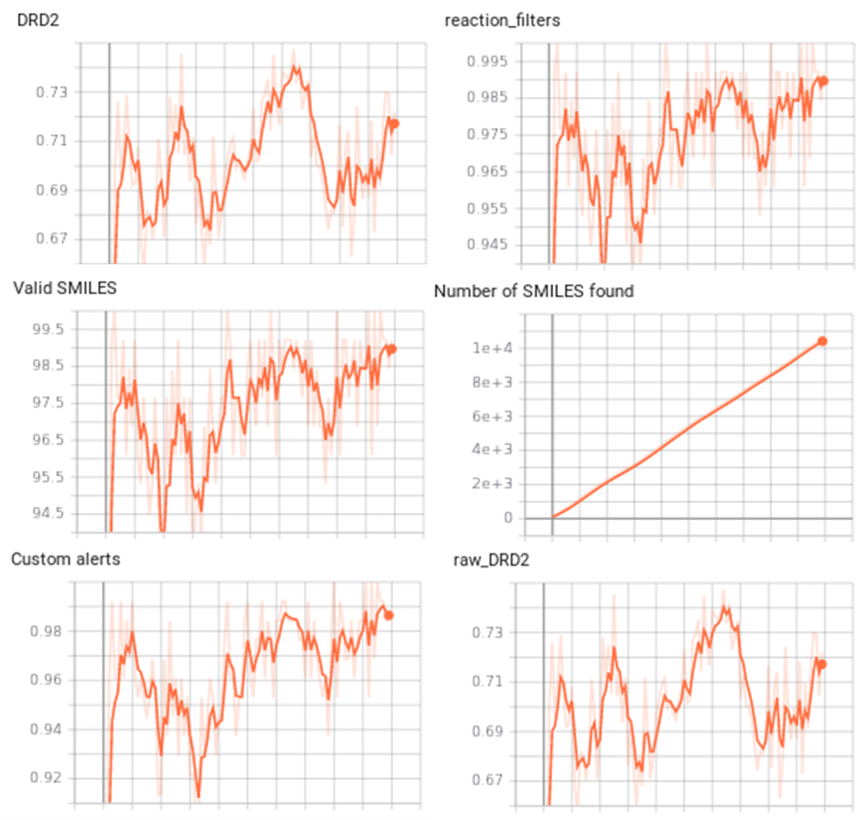
The average score is getting up quickly which means the model is learning fast. The average score for each step is above 0.60 which indicates a rather good result. It is worth noting that an increasing trend is not expected throughout the run for Lib-INVENT since the model starts in a "good place" and only needs to focus during the production of the chemical library.
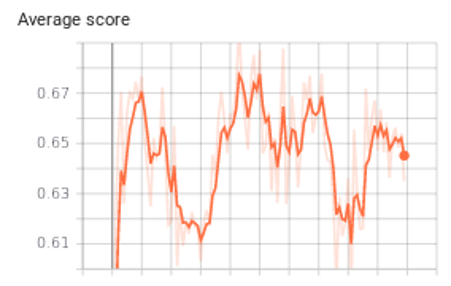

It might also be informative to look at the results from the prior (dark blue), the agent (blue) and the augmented likelihood (purple) over time.

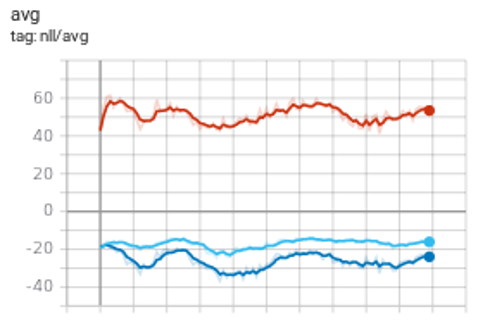

And last but not least, there is a "Images" tab available that lets you browse through the compounds generated in an easy way. There is also a scroll bar which can be scrolled to se the molecules generated at each step. The total scores are given per molecule. The example below is from step 100.

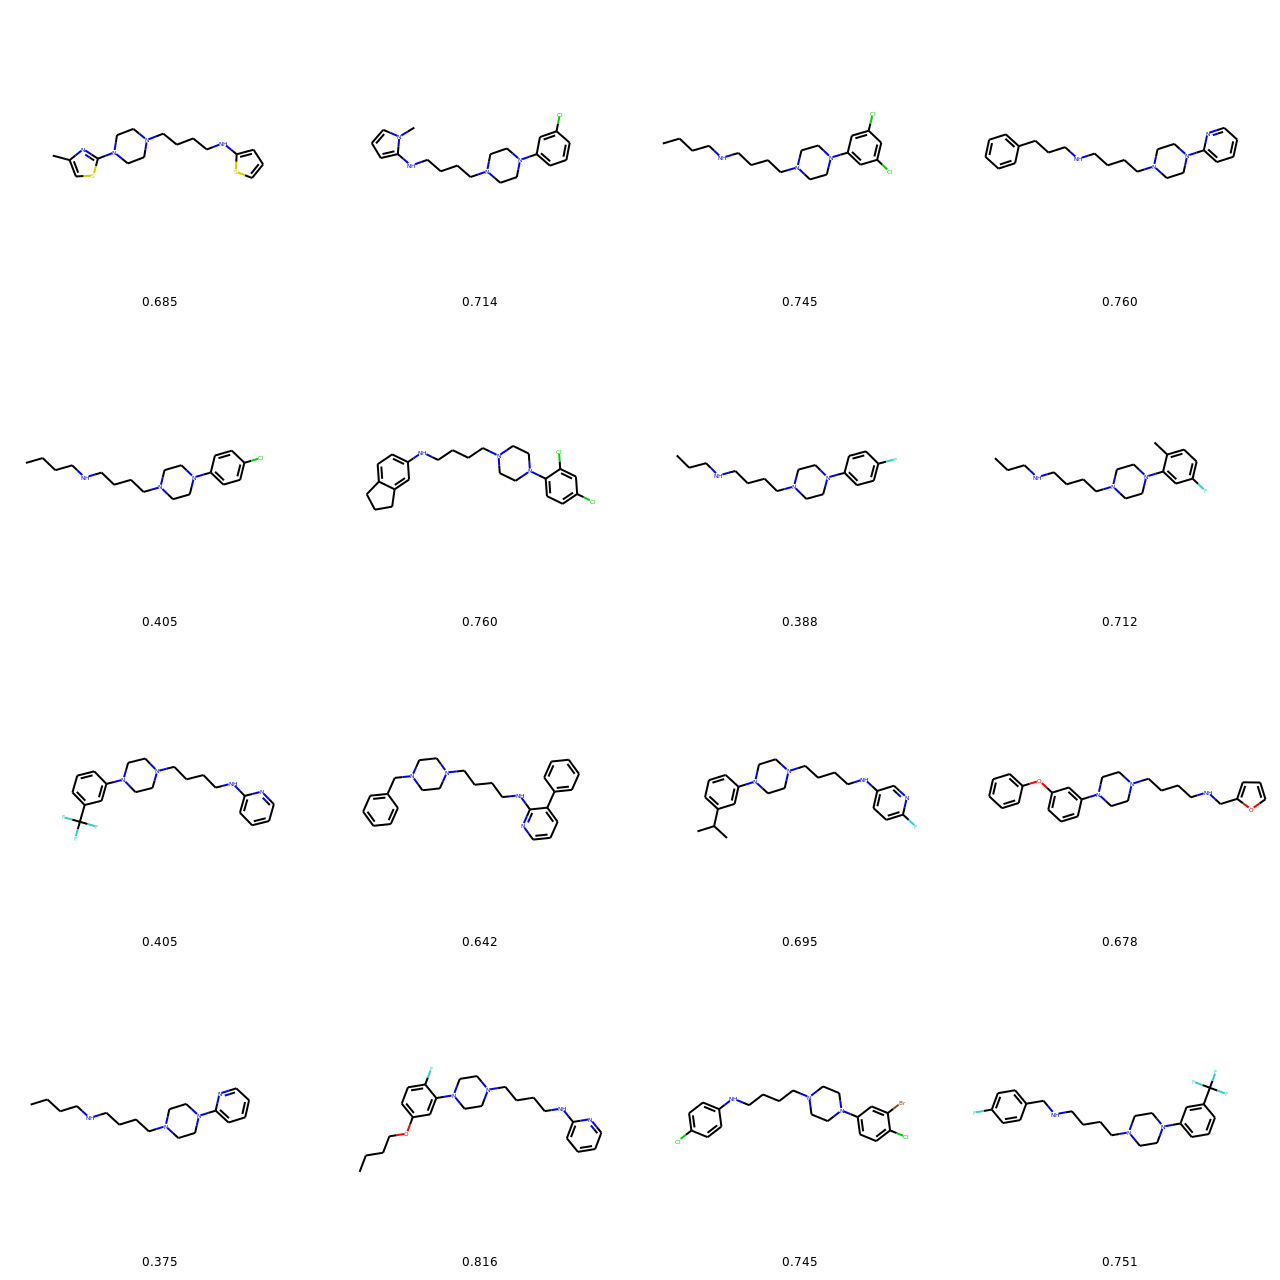

## Show top compounds
All valid compounds with scores over 0.4 can be found in the scaffold_memory.csv file.The SMILES are ranked by their total scores from high to low. 

note: scaffold_memory.csv contains SMILES, Scaffolds, Decorations, Scores from different components and Total score.

RDKit WARNING: [15:19:06] Enabling RDKit 2019.09.3 jupyter extensions


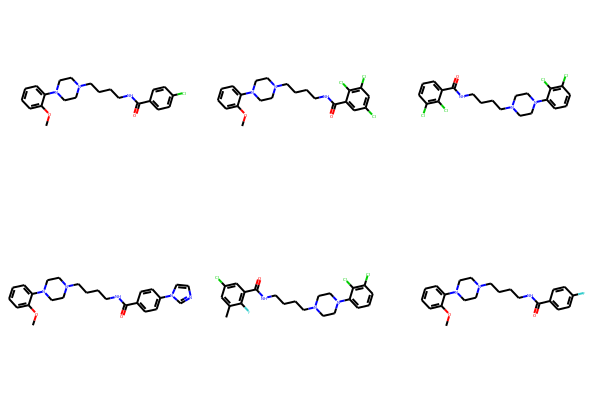

In [12]:
# import needed packages
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

scaffold_memory_path = os.path.join(output_dir, 'results/scaffold_memory.csv')
data = pd.read_csv(scaffold_memory_path)
smile_list = data['SMILES'][:6].to_list() # change the number here to show more/less top compounds
mols = [Chem.MolFromSmiles(smiles) for smiles in smile_list]
Draw.MolsToGridImage(mols)